In [1]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from scipy import fft, fftpack
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './'

%matplotlib inline

In [2]:
x = np.load("waveform_x.np.npy")

In [6]:
m = 128
k = 100 # number of frequency bins?
d = 4096 # size of windows?
window = 16384 # total number of audio samples?
stride = 512
regions = 1 + (window - d)//stride # number of output after sliding the window through x

# Musicnet Approach

In [7]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [8]:
wsin, wcos = create_filters(d,k)

In [10]:
wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)

In [12]:
zx = conv1d(torch.from_numpy(x)[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(torch.from_numpy(x)[:,None,:], wcos_var, stride=stride).pow(2)

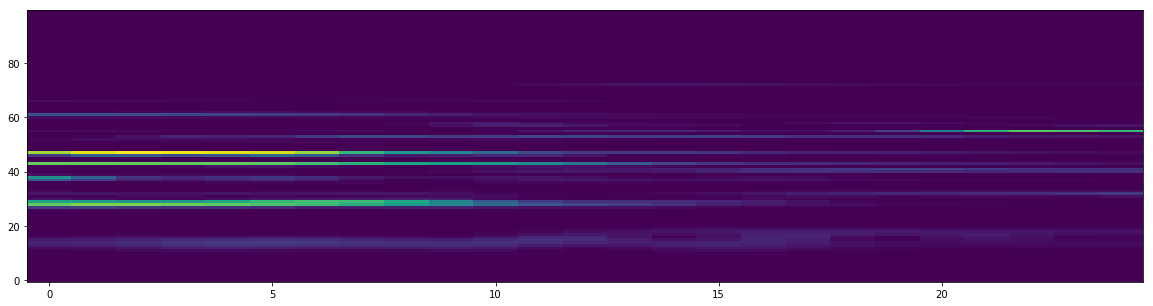

In [13]:
Xs = zx.cpu().numpy()

fig = plt.figure(figsize=(20,5))
plt.imshow(Xs[0],aspect='auto')
plt.gca().invert_yaxis()

# Scipy approach

In [15]:
X_list = []
for i in range(25):
    X_list.append(np.abs(fft(x[0][i*stride:i*stride+d])))

In [16]:
X_list = np.array(X_list)

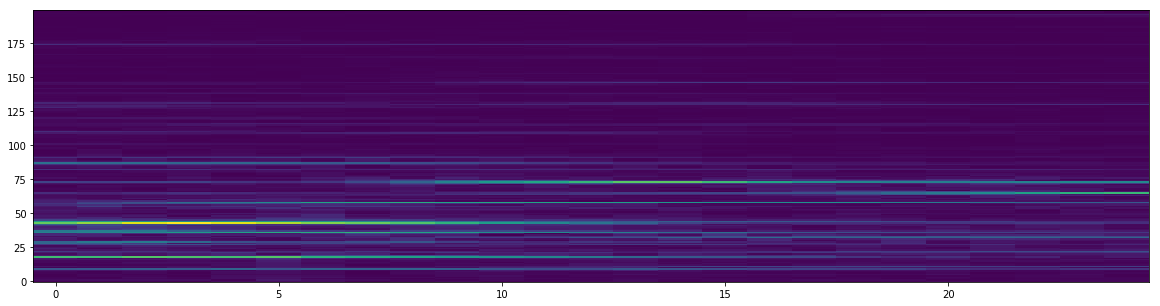

In [17]:
fig = plt.figure(figsize=(20,5))
plt.imshow(X_list.T[:200],aspect='auto')
plt.gca().invert_yaxis()